In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";  

In [3]:
# LeNet for MNIST using Keras and TensorFlow

from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import LeakyReLU
from keras.utils import np_utils
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten
from keras.layers.core import Permute, Reshape
from keras import backend as K
from keras import optimizers
from keras.models import load_model
np.random.seed(2)


# use GPU mem incrementally
import tensorflow as tf
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.compat.v1.Session(config=config)
# from keras import backend as K
# K.set_session(sess)


Using TensorFlow backend.


In [4]:
# import for c3d
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution3D, MaxPooling3D, ZeroPadding3D
from keras import optimizers
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *

In [5]:
from utils import *
from neurallogic import *
from lenet import *
from data_prepare import *
from intergrated_model import *

In [6]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 123
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)
# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

# # 5. Configure a new global `tensorflow` session
# from keras import backend as K
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)

In [7]:
# set global parameters
plot_epoch = 500

saved_result_data = 'result_data/marc_sim_win15.pkl'

# CE definition

In [8]:
simulation_name = 'marc_sim_win15'

############## CE definition ##############

NL_model_name = 'NL_' + simulation_name
PL_model_name = 'PNL_' + simulation_name


num_event_type = 10   # total num of unique events  3x3 + 1 unknown
num_attribute = 1      # total num of attribute (int)

ce_fsm_list = [ [1,1],[2,2],[3,3],[4,4],[5,5],[6,6],[7,7],[8,8],[9,9],[10,10]]
#                 [1,2], [3,4],[5,6],[7,8],[9,10]]
ce_time_list = [ np.array([ [INF], [0]]),
                np.array([[INF], [0]]),
                np.array([[INF], [0]]),
                np.array([[INF], [0]]),
                np.array([[INF], [0]]),
                np.array([[INF], [0]]),
                np.array([[INF], [0]]),
               np.array([[INF], [0]]),
                np.array([[INF], [0]]),
#                   np.array([[INF], [0]]),
#                 np.array([[INF], [0]]),
#                 np.array([[INF], [0]]),
#                 np.array([[INF], [0]]),
#                 np.array([[INF], [0]]),
                np.array([[INF], [0]])
               ]

event_num = 100000
window_size = 15

# Training Neural Logic Models

In [9]:
train_neurallogic_model(NL_model_name,
                            num_event_type, num_attribute,
                            ce_fsm_list, ce_time_list,
                            window_size,
                            event_num ,
                            verify_logic = False,
                            diagnose = True)

NeuralLogic model exists in:  saved_model/NL_marc_sim_win15.hdf5


In [10]:
# Returns a compiled model identical to the previous one
loading_path = 'saved_model/'+NL_model_name+'.hdf5'
neuralLogic_model = load_model(loading_path)
neuralLogic_model.name="neurallogic"
print('Loading model successfully from ', loading_path)

Loading model successfully from  saved_model/NL_marc_sim_win15.hdf5


# Preparing all dataset required

In [11]:
mnist_event_num = 100000

In [12]:
mnist_data_event_path = PL_model_name+'_data_' + str(mnist_event_num) +'.npz'
mnist_data_event, data_feature, data_label = generate_mnist_event_data(num_event_type, num_attribute, 
                                                                          ce_fsm_list, ce_time_list,
                                                                          mnist_event_num, window_size,
                                                                          mnist_data_event_path)

Data file exists in:  data/PNL_marc_sim_win15_data_100000.npz


In [13]:
if np.ndim(data_label)==1:
    data_label = np.expand_dims(data_label, axis = 1)

# valid_index = (data_label!= 999)# choose valid data samples
valid_index = (data_label.sum(axis = 1)!= 0)
v_mnist_data_event  =  mnist_data_event[valid_index, ]
v_data_label = data_label[valid_index, ]
print('Valid data (with valid CE) shape: ')
print("Data:\t", v_mnist_data_event.shape)
print("Label:\t", v_data_label.shape)

Valid data (with valid CE) shape: 
Data:	 (77163, 15, 28, 28, 1)
Label:	 (77163, 10)


In [14]:
# prepare the testing MNIST dataset for customized LeNet
mnist_label = list(range(num_event_type)) # 
mnist_x_test, mnist_y_test = generate_customized_mnist_data(mnist_label, num_event_type)

Testing mnist feature shape:  (10000, 28, 28, 1)
Testing mnist label shape:  (10000, 10)


In [15]:
v_mnist_data_event = v_mnist_data_event *2 -1
mnist_x_test = mnist_x_test *2 -1

print(v_mnist_data_event.min(), v_mnist_data_event.max() )
print(v_data_label.sum(axis = 0))

-1.0 1.0
[14019. 14117. 13822. 13542. 14207. 14191. 14075. 13897. 13649. 14412.]


# 1.Training in end2end fashion:
### MSE loss + Adam(0.001)
### Combined loss doesn't work really well, stucked at local minima

In [30]:
# generate a new LeNet model from scratch
lenetModel = LeNet_mnist(num_output = num_event_type)  # 2 events
lenetModel.name="lenetModel"
score = lenetModel.evaluate(mnist_x_test, mnist_y_test, verbose=1)
print('Test loss: %3f,  \t \tTest Accuracy: %4f'%(score[0], score[1]))

final_model = intergrated_model(lenetModel, neuralLogic_model, 
                                window_size, num_event_type,
                                omega_value = 1e-4,
                                load_nl_weights = True,
                                nl_trainable = False,
                                loss = 'combined_loss',  # use semantic loss here
#                                 loss = 'mse_loss',  # use semantic loss here
                                diagnose = False)
# loss = combined_loss / mse_loss

10000/10000 [==============================] - 1s 84us/step
Test loss: 2.341746,  	 	Test Accuracy: 0.109600
Model input:  Tensor("input_3:0", shape=(None, 15, 28, 28, 1), dtype=float32)
Model output:  Tensor("dense_9/BiasAdd:0", shape=(None, 10), dtype=float32)

===== NL model weights loaded =====

===== Neural Logic module freezed.=====

===== Loss Func: Combined Loss =====
 Omega =  0.0001


In [31]:
plot_epoch = 500
epochs = plot_epoch
diagnose = True

save_path = 'saved_model/'+ PL_model_name +'.hdf5'
es = EarlyStopping(monitor='val_MAE', mode='min', verbose=1, patience=plot_epoch)
mc = ModelCheckpoint(save_path, monitor='val_MAE', mode='min', verbose=diagnose, save_best_only=True)
cb_list = [es, mc]

print('The maximum training epochs is: ', epochs)
H = final_model.fit( v_mnist_data_event[:1000] ,v_data_label[:1000], 
                        batch_size = 32, 
#                         batch_size = 256, 
                        epochs = epochs,
                        verbose=diagnose,
                        shuffle=True,
                        callbacks=cb_list,
                        validation_split = 0.2)

hist_NL = H

The maximum training epochs is:  500
Train on 800 samples, validate on 200 samples
Epoch 1/500
800/800 [==============================] - 2s 3ms/step - loss: 0.5927 - MAE: 0.5852 - val_loss: 0.4450 - val_MAE: 0.5465

Epoch 00001: val_MAE improved from inf to 0.54649, saving model to saved_model/PNL_marc_sim_win15.hdf5
Epoch 2/500
800/800 [==============================] - 1s 2ms/step - loss: 0.4261 - MAE: 0.5045 - val_loss: 0.3403 - val_MAE: 0.4326

Epoch 00002: val_MAE improved from 0.54649 to 0.43260, saving model to saved_model/PNL_marc_sim_win15.hdf5
Epoch 3/500
800/800 [==============================] - 1s 2ms/step - loss: 0.3020 - MAE: 0.3547 - val_loss: 0.2457 - val_MAE: 0.2772

Epoch 00003: val_MAE improved from 0.43260 to 0.27719, saving model to saved_model/PNL_marc_sim_win15.hdf5
Epoch 4/500
800/800 [==============================] - 1s 2ms/step - loss: 0.2028 - MAE: 0.2303 - val_loss: 0.1788 - val_MAE: 0.2028

Epoch 00004: val_MAE improved from 0.27719 to 0.20279, saving mo


Epoch 00036: val_MAE did not improve from 0.03629
Epoch 37/500
800/800 [==============================] - 1s 2ms/step - loss: 0.0064 - MAE: 0.0158 - val_loss: 0.0267 - val_MAE: 0.0376

Epoch 00037: val_MAE did not improve from 0.03629
Epoch 38/500
800/800 [==============================] - 1s 2ms/step - loss: 0.0053 - MAE: 0.0139 - val_loss: 0.0252 - val_MAE: 0.0340

Epoch 00038: val_MAE improved from 0.03629 to 0.03398, saving model to saved_model/PNL_marc_sim_win15.hdf5
Epoch 39/500
800/800 [==============================] - 1s 2ms/step - loss: 0.0049 - MAE: 0.0130 - val_loss: 0.0270 - val_MAE: 0.0357

Epoch 00039: val_MAE did not improve from 0.03398
Epoch 40/500
800/800 [==============================] - 1s 2ms/step - loss: 0.0050 - MAE: 0.0128 - val_loss: 0.0255 - val_MAE: 0.0349

Epoch 00040: val_MAE did not improve from 0.03398
Epoch 41/500
800/800 [==============================] - 1s 2ms/step - loss: 0.0047 - MAE: 0.0124 - val_loss: 0.0269 - val_MAE: 0.0368

Epoch 00041: val_

800/800 [==============================] - 1s 2ms/step - loss: 0.0021 - MAE: 0.0045 - val_loss: 0.0200 - val_MAE: 0.0249

Epoch 00119: val_MAE did not improve from 0.02449
Epoch 120/500
800/800 [==============================] - 1s 2ms/step - loss: 0.0021 - MAE: 0.0045 - val_loss: 0.0200 - val_MAE: 0.0249

Epoch 00120: val_MAE did not improve from 0.02449
Epoch 121/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0021 - MAE: 0.0044 - val_loss: 0.0201 - val_MAE: 0.0249

Epoch 00121: val_MAE did not improve from 0.02449
Epoch 122/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0021 - MAE: 0.0044 - val_loss: 0.0200 - val_MAE: 0.0250

Epoch 00122: val_MAE did not improve from 0.02449
Epoch 123/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0021 - MAE: 0.0044 - val_loss: 0.0200 - val_MAE: 0.0248

Epoch 00123: val_MAE did not improve from 0.02449
Epoch 124/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0021 

800/800 [==============================] - 1s 1ms/step - loss: 0.0448 - MAE: 0.0338 - val_loss: 0.0821 - val_MAE: 0.0508

Epoch 00207: val_MAE did not improve from 0.02449
Epoch 208/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0342 - MAE: 0.0273 - val_loss: 0.0726 - val_MAE: 0.0452

Epoch 00208: val_MAE did not improve from 0.02449
Epoch 209/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0295 - MAE: 0.0242 - val_loss: 0.0461 - val_MAE: 0.0329

Epoch 00209: val_MAE did not improve from 0.02449
Epoch 210/500
800/800 [==============================] - 1s 2ms/step - loss: 0.0248 - MAE: 0.0205 - val_loss: 0.0501 - val_MAE: 0.0351

Epoch 00210: val_MAE did not improve from 0.02449
Epoch 211/500
800/800 [==============================] - 1s 2ms/step - loss: 0.0274 - MAE: 0.0222 - val_loss: 0.0534 - val_MAE: 0.0372

Epoch 00211: val_MAE did not improve from 0.02449
Epoch 212/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0213 


Epoch 00250: val_MAE did not improve from 0.02261
Epoch 251/500
800/800 [==============================] - 1s 2ms/step - loss: 0.0063 - MAE: 0.0075 - val_loss: 0.0487 - val_MAE: 0.0318

Epoch 00251: val_MAE did not improve from 0.02261
Epoch 252/500
800/800 [==============================] - 1s 2ms/step - loss: 0.0060 - MAE: 0.0073 - val_loss: 0.0480 - val_MAE: 0.0311

Epoch 00252: val_MAE did not improve from 0.02261
Epoch 253/500
800/800 [==============================] - 1s 2ms/step - loss: 0.0057 - MAE: 0.0070 - val_loss: 0.0475 - val_MAE: 0.0311

Epoch 00253: val_MAE did not improve from 0.02261
Epoch 254/500
800/800 [==============================] - 1s 2ms/step - loss: 0.0057 - MAE: 0.0069 - val_loss: 0.0477 - val_MAE: 0.0311

Epoch 00254: val_MAE did not improve from 0.02261
Epoch 255/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0059 - MAE: 0.0070 - val_loss: 0.0475 - val_MAE: 0.0310

Epoch 00255: val_MAE did not improve from 0.02261
Epoch 256/500
800/8

800/800 [==============================] - 1s 2ms/step - loss: 0.0049 - MAE: 0.0059 - val_loss: 0.0393 - val_MAE: 0.0269

Epoch 00295: val_MAE did not improve from 0.02261
Epoch 296/500
800/800 [==============================] - 1s 2ms/step - loss: 0.0049 - MAE: 0.0059 - val_loss: 0.0392 - val_MAE: 0.0269

Epoch 00296: val_MAE did not improve from 0.02261
Epoch 297/500
800/800 [==============================] - 1s 2ms/step - loss: 0.0049 - MAE: 0.0059 - val_loss: 0.0391 - val_MAE: 0.0268

Epoch 00297: val_MAE did not improve from 0.02261
Epoch 298/500
800/800 [==============================] - 1s 2ms/step - loss: 0.0049 - MAE: 0.0059 - val_loss: 0.0391 - val_MAE: 0.0268

Epoch 00298: val_MAE did not improve from 0.02261
Epoch 299/500
800/800 [==============================] - 1s 2ms/step - loss: 0.0049 - MAE: 0.0059 - val_loss: 0.0390 - val_MAE: 0.0268

Epoch 00299: val_MAE did not improve from 0.02261
Epoch 300/500
800/800 [==============================] - 1s 2ms/step - loss: 0.0049 

800/800 [==============================] - 1s 2ms/step - loss: 0.0046 - MAE: 0.0057 - val_loss: 0.0403 - val_MAE: 0.0272

Epoch 00383: val_MAE did not improve from 0.02261
Epoch 384/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0046 - MAE: 0.0057 - val_loss: 0.0403 - val_MAE: 0.0272

Epoch 00384: val_MAE did not improve from 0.02261
Epoch 385/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0046 - MAE: 0.0057 - val_loss: 0.0403 - val_MAE: 0.0272

Epoch 00385: val_MAE did not improve from 0.02261
Epoch 386/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0046 - MAE: 0.0057 - val_loss: 0.0403 - val_MAE: 0.0272

Epoch 00386: val_MAE did not improve from 0.02261
Epoch 387/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0046 - MAE: 0.0057 - val_loss: 0.0404 - val_MAE: 0.0272

Epoch 00387: val_MAE did not improve from 0.02261
Epoch 388/500
800/800 [==============================] - 1s 2ms/step - loss: 0.0046 

800/800 [==============================] - 1s 2ms/step - loss: 0.0046 - MAE: 0.0057 - val_loss: 0.0410 - val_MAE: 0.0274

Epoch 00471: val_MAE did not improve from 0.02261
Epoch 472/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0046 - MAE: 0.0057 - val_loss: 0.0410 - val_MAE: 0.0274

Epoch 00472: val_MAE did not improve from 0.02261
Epoch 473/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0046 - MAE: 0.0057 - val_loss: 0.0410 - val_MAE: 0.0274

Epoch 00473: val_MAE did not improve from 0.02261
Epoch 474/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0046 - MAE: 0.0057 - val_loss: 0.0411 - val_MAE: 0.0274

Epoch 00474: val_MAE did not improve from 0.02261
Epoch 475/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0046 - MAE: 0.0057 - val_loss: 0.0411 - val_MAE: 0.0274

Epoch 00475: val_MAE did not improve from 0.02261
Epoch 476/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0046 

# moniter the lenet performance 

In [32]:
lenet_score1 = lenetModel.evaluate(mnist_x_test, mnist_y_test, verbose=0)
# print('Test loss: %3f,  \t \tTest Accuracy: %4f'%(lenet_score1[0], lenet_score1[1]))
print('Proposed acc:\t %4f'%(lenet_score1[1]))
# lenet_score2 = lenetModel_2.evaluate(mnist_x_test, mnist_y_test, verbose=0)
# print('Ablation acc:\t %4f'%(lenet_score2[1]))

Proposed acc:	 0.962600


dict_keys(['val_loss', 'val_MAE', 'loss', 'MAE'])


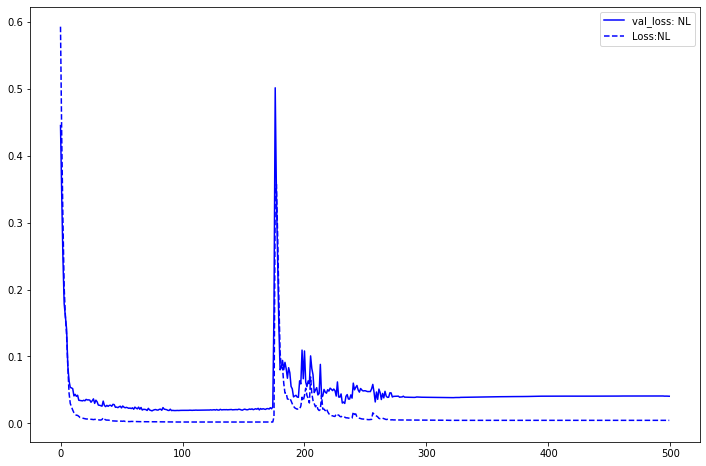

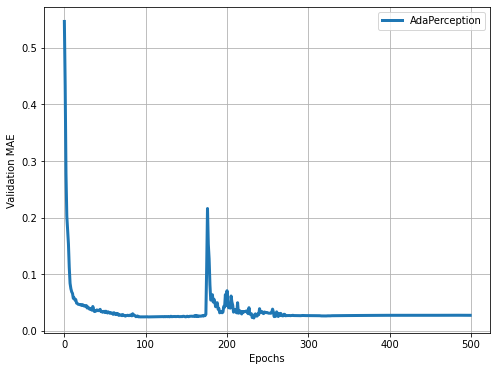

In [33]:
# evaluation: plot the learning curves
hist_NL = H
hist1 = hist_NL.history
print(hist1.keys() )

import matplotlib.pyplot as plt
# # loss figure
fig = plt.figure(figsize=(12,8))
plt.plot(hist1['val_loss'], 'b-')
plt.plot(hist1['loss'], 'b--')
plt.legend(['val_loss: NL', 'Loss:NL', 'val_loss', 'Loss'])
plt.show()

# MAE figure
fig = plt.figure(figsize=(8, 6))
plt.plot(hist1['val_MAE'], '-', linewidth=3)
# plt.plot(hist2['val_MAE'], '-', linewidth=3)
# plt.plot(hist3['val_MAE'], '-', linewidth=3)
# plt.plot(hist4['val_mae'], '-', linewidth=3)

# plt.plot(hist1['MAE'], '-')
# plt.plot(hist2['MAE'], '-')
# plt.plot(hist3['MAE'], '-')
# plt.plot(hist4['mae'], '-')

plt.legend(['AdaPerception', 'AdaPerception w/o L_semantic', 'Training from scratch', 'C3D model'])
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.savefig('filename.png', dpi=600)
plt.show()
